In [1]:
import torch
import datasets
import os
import aqlm
import time
import numpy as np


In [2]:
import sys
sys.path.append("d:\\projects\\affect\\TUCORE-GCN\\tucore_gcn_transformers")
sys.path.append("d:\\projects\\affect\\TUCORE-GCN\\")
sys.path

['d:\\projects\\affect\\TUCORE-GCN',
 'C:\\Users\\picokatx\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip',
 'C:\\Users\\picokatx\\AppData\\Local\\Programs\\Python\\Python311\\DLLs',
 'C:\\Users\\picokatx\\AppData\\Local\\Programs\\Python\\Python311\\Lib',
 'C:\\Users\\picokatx\\AppData\\Local\\Programs\\Python\\Python311',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv',
 '',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv\\Lib\\site-packages',
 'D:\\projects\\affect\\TUCORE-GCN\\AQLM\\src',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv\\Lib\\site-packages\\win32',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv\\Lib\\site-packages\\win32\\lib',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv\\Lib\\site-packages\\Pythonwin',
 'd:\\projects\\affect\\TUCORE-GCN\\tucore_gcn_transformers',
 'd:\\projects\\affect\\TUCORE-GCN\\']

In [3]:
from flash_attn.models.bert import BertModel, BertConfig
bm = BertModel(BertConfig.from_json_file("./models/BERT/tucoregcn_bert_mlc.json"))
bm

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
  )
  (emb_drop): Dropout(p=0.1, inplace=False)
  (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (encoder): BertEncoder(
    (layers): ModuleList(
      (0-11): 12 x Block(
        (mixer): MHA(
          (Wqkv): FusedDense(in_features=768, out_features=2304, bias=True)
          (inner_attn): FlashSelfAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (inner_cross_attn): FlashCrossAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (out_proj): FusedDense(in_features=768, out_features=768, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (mlp): FusedMLP(
    

In [4]:
bm.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
)

In [3]:
from tucore_gcn_transformers.berttest import remap_state_dict
from tucore_gcn_bert_modelling import TUCOREGCN_BertForSequenceClassification, TUCOREGCN_BertConfig
from transformers.models.bert.modeling_bert import BertForSequenceClassification
config = TUCOREGCN_BertConfig.from_json_file("./models/BERT/tucoregcn_bert_mlc.json")
bertmodel = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
new_statedict = remap_state_dict(bertmodel.state_dict(), config=config)

In [16]:
from safetensors.torch import save_file
save_file(new_statedict, "./pre-trained_model/BERT/flash_compatible.safetensors")

In [12]:
bertmodel.state_dict()

OrderedDict([('tucoregcn_bert.bert.embeddings.word_embeddings.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [-0.0174,  0.0138, -0.0058,  ...,  0.0100, -0.0070, -0.0147],
                      [ 0.0276,  0.0204,  0.0104,  ...,  0.0056, -0.0036,  0.0004],
                      ...,
                      [-0.0285,  0.0349, -0.0096,  ..., -0.0025,  0.0105,  0.0040],
                      [ 0.0393, -0.0251,  0.0253,  ..., -0.0045, -0.0162, -0.0289],
                      [ 0.0044, -0.0194,  0.0154,  ...,  0.0369,  0.0053,  0.0077]])),
             ('tucoregcn_bert.bert.embeddings.position_embeddings.weight',
              tensor([[ 0.0098,  0.0252, -0.0081,  ...,  0.0010,  0.0104,  0.0320],
                      [ 0.0169,  0.0228, -0.0012,  ...,  0.0107,  0.0369, -0.0190],
                      [-0.0305, -0.0021, -0.0096,  ...,  0.0184,  0.0057, -0.0324],
                      ...,
                      [ 0.0016,  0.0117, 

In [20]:
np.random.seed(0)
torch.random.manual_seed(9)
# coding=utf-8
# Copyright 2022 EleutherAI and the HuggingFace Inc. team. All rights reserved.
#
# This code is based on EleutherAI's GPT-NeoX library and the GPT-NeoX
# and OPT implementations in this library. It has been modified from its
# original forms to accommodate minor architectural differences compared
# to GPT-NeoX and OPT used by the Meta AI team that trained the model.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" PyTorch LLaMA model."""
import math
import warnings
from typing import List, Optional, Tuple, Union

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.activations import ACT2FN
from transformers.cache_utils import Cache, DynamicCache, StaticCache
from transformers.modeling_outputs import (
    BaseModelOutput,
    BaseModelOutputWithPast,
    CausalLMOutputWithPast,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutputWithPast,
    SequenceClassifierOutput,
)
from transformers.modeling_utils import PreTrainedModel
from transformers.configuration_utils import PretrainedConfig
from transformers.pytorch_utils import ALL_LAYERNORM_LAYERS
from transformers.utils import (
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    is_flash_attn_2_available,
    is_flash_attn_greater_or_equal_2_10,
    logging,
    replace_return_docstrings,
)
from transformers.models.llama.configuration_llama import LlamaConfig
import os

if is_flash_attn_2_available():
    os.add_dll_directory(os.path.join(os.environ['CUDA_PATH'], 'bin'))
    from flash_attn import flash_attn_func, flash_attn_varlen_func
    from flash_attn.bert_padding import index_first_axis, pad_input, unpad_input  # noqa

import dgl
import dgl.nn.pytorch as dglnn

logger = logging.get_logger(__name__)

_CONFIG_FOR_DOC = "LlamaConfig"

from transformers.models.llama.modeling_llama import LLAMA_ATTENTION_CLASSES, LlamaMLP, LlamaRMSNorm

class LlamaDecoderLayer(nn.Module):
    def __init__(self, config: LlamaConfig, layer_idx: int):
        super().__init__()
        self.hidden_size = config.hidden_size

        self.self_attn = LLAMA_ATTENTION_CLASSES[config._attn_implementation](config=config, layer_idx=layer_idx)

        self.mlp = LlamaMLP(config)
        self.input_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`, *optional*):
                attention mask of size `(batch_size, sequence_length)` if flash attention is used or `(batch_size, 1,
                query_sequence_length, key_sequence_length)` if default attention is used.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            use_cache (`bool`, *optional*):
                If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding
                (see `past_key_values`).
            past_key_value (`Tuple(torch.FloatTensor)`, *optional*): cached past key and value projection states
        """
        if "padding_mask" in kwargs:
            warnings.warn(
                "Passing `padding_mask` is deprecated and will be removed in v4.37. Please make sure use `attention_mask` instead.`"
            )
        # For fused:
        # Dropout -> Add -> LN
    	# -> MHA ->
        # Dropout -> Add -> LN
        # -> MLP
        residual = hidden_states
        # LN
        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        # LN -> MHA -> Dropout
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
            use_cache=use_cache,
            cache_position=cache_position,
            **kwargs,
        )
        # LN -> MHA -> Dropout -> Add
        hidden_states = residual + hidden_states

        # Fully Connected
        residual = hidden_states
        # LN -> MHA -> Dropout -> Add -> LN
        hidden_states = self.post_attention_layernorm(hidden_states)
        # LN -> MHA -> Dropout -> Add -> LN -> MLP -> Dropout
        hidden_states = self.mlp(hidden_states)
        # LN -> MHA -> Dropout -> Add -> LN -> MLP -> Dropout -> Add
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights,)

        if use_cache:
            outputs += (present_key_value,)

        return outputs
dl = LlamaDecoderLayer(LlamaConfig.from_json_file("./llama_config.json"), 0).to("cuda", dtype=torch.float16)
dl(torch.rand(((1, 512, 2048)), device="cuda", dtype=torch.float16), attention_mask = torch.ones((1, 512), device="cuda", dtype=torch.float16), position_ids = torch.tensor([list(range(0,512))], device="cuda", dtype=torch.long))

(tensor([[[0.5239, 0.5308, 0.5342,  ..., 0.4512, 0.6802, 0.8755],
          [0.0210, 0.5815, 0.8091,  ..., 1.0566, 0.7070, 1.1670],
          [0.1770, 0.9795, 0.9004,  ..., 0.9893, 0.6558, 1.0498],
          ...,
          [0.2417, 0.0913, 0.7861,  ..., 0.7217, 0.8843, 0.6719],
          [0.4082, 0.9844, 0.6338,  ..., 0.6611, 0.3215, 1.3887],
          [0.0468, 0.6470, 0.8389,  ..., 0.4219, 1.0020, 0.7178]]],
        device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>),)

In [3]:
from flash_attn_bert_no_way import BertModel as FlashBertModel, BertConfig as FlashBertConfig
model = FlashBertModel(FlashBertConfig.from_json_file("./pre-trained_model/BERT/bert_config.json"))

In [4]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
  )
  (emb_drop): Dropout(p=0.1, inplace=False)
  (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (encoder): BertEncoder(
    (layers): ModuleList(
      (0-11): 12 x Block(
        (mixer): MHA(
          (Wqkv): LinearResidual(in_features=768, out_features=2304, bias=True)
          (inner_attn): SelfAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (inner_cross_attn): CrossAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Li

In [5]:
from transformers import AutoModelForPreTraining
tmodel = AutoModelForPreTraining.from_pretrained('bert-base-uncased')
tmodel

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## galore testing + introspecting flashattn for nopad speedup

In [7]:
torch._dynamo.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'openxla_eval', 'tvm']

In [8]:
from flash_attn.flash_attn_interface import flash_attn_varlen_func

In [9]:
%%timeit -r 64
flash_attn_varlen_func(
	torch.rand((429,4,64), dtype=torch.float16, device="cuda"),
	torch.rand((429,4,64), dtype=torch.float16, device="cuda"),
	torch.rand((429,4,64), dtype=torch.float16, device="cuda"),
	torch.tensor([0, 226, 429], dtype=torch.int32, device="cuda"),
	torch.tensor([0, 226, 429], dtype=torch.int32, device="cuda"),
	226,
	226,
	0.0, None, True
)

194 µs ± 52.8 µs per loop (mean ± std. dev. of 64 runs, 1 loop each)


In [10]:
%%timeit -r 64
flash_attn_varlen_func(
	torch.rand((429,4,64), dtype=torch.float16, device="cuda"),
	torch.rand((429,4,64), dtype=torch.float16, device="cuda"),
	torch.rand((429,4,64), dtype=torch.float16, device="cuda"),
	torch.tensor([0, 226, 429], dtype=torch.int32, device="cuda"),
	torch.tensor([0, 226, 429], dtype=torch.int32, device="cuda"),
	512,
	512,
	0.0, None, True
).shape

In [3]:
from transformers import LlamaModel, AutoTokenizer, LlamaForCausalLM, LlamaConfig, LlamaForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("BlackSamorez/TinyLlama-1_1B-Chat-v1_0-AQLM-2Bit-1x16-hf")
# _attn_implementation: flash_attention_2
model = LlamaForSequenceClassification.from_pretrained(
    "BlackSamorez/TinyLlama-1_1B-Chat-v1_0-AQLM-2Bit-1x16-hf",
	config=LlamaConfig.from_json_file("./llama_config.json"),
    ignore_mismatched_sizes=True,
	torch_dtype="auto", device_map="auto", low_cpu_mem_usage=True
)
model.cuda()
model.train()
model.num_parameters()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at BlackSamorez/TinyLlama-1_1B-Chat-v1_0-AQLM-2Bit-1x16-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


267885568

In [4]:
from peft import AdaLoraConfig, get_peft_model, IA3Model, IA3Config, LoraConfig

ada_lora_config = AdaLoraConfig(
    r=8,
    init_r=12,
    tinit=200,
    tfinal=1000,
    deltaT=10,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    modules_to_save=["score"],
)

lora_config = LoraConfig(
    r=64,
    lora_alpha=256,
	inference_mode = False,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.01,
)
ia3_config = IA3Config(
    peft_type="IA3",
    target_modules=["key", "value", "dense"],
    feedforward_modules=["dense"],
)

peft_model = get_peft_model(model, lora_config)
peft_model.get_parameter("base_model.model.score.weight").requires_grad = True
peft_model.get_parameter("base_model.model.score.weight").data = peft_model.get_parameter("base_model.model.score.weight").data.to(torch.float32)
peft_model.print_trainable_parameters()

trainable params: 50,475,008 || all params: 318,348,288 || trainable%: 15.855278606053004


In [5]:
peft_model
# lora_A/lora_B

PeftModel(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048, padding_idx=2)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): lora.AqlmLoraLinear(
                (base_layer): QuantizedLinear()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.AqlmLoraLinear(
                (base_layer): QuantizedLinear()
   

In [ ]:
from peft.tuners.lora.aqlm import AqlmLoraLinear
galore_params = []
target_modules_list = ["self_attn", "mlp"]
for module_name, module in peft_model.named_modules():
    if not isinstance(module, AqlmLoraLinear):
        continue

    if not any(target_key in module_name for target_key in target_modules_list):
        continue
    
    galore_params.append(module.lora_A.default.weight)
    galore_params.append(module.lora_B.default.weight)

In [ ]:
id_galore_params = [id(p) for p in galore_params]
# make parameters without "rank" to another group
regular_params = [p for p in model.parameters() if id(p) not in id_galore_params]
# then call galore_adamw
param_groups = [{'params': regular_params}, 
				{'params': galore_params, 'rank': 64, 'update_proj_gap': 200, 'scale': 0.25, 'proj_type': 'std'}]

In [ ]:
from galore_torch import GaLoreAdamW8bit
optimizer = GaLoreAdamW8bit(param_groups, lr=0.01)

In [ ]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048, padding_idx=2)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): QuantizedLinear()
          (k_proj): QuantizedLinear()
          (v_proj): QuantizedLinear()
          (o_proj): QuantizedLinear()
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): QuantizedLinear()
          (up_proj): QuantizedLinear()
          (down_proj): QuantizedLinear()
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (score): Linear(in_features=2048, out_features=6, bias=False)
)

In [ ]:
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb, _get_unpad_data
from flash_attn.bert_padding import unpad_input, index_first_axis
pos_ids = torch.tensor([list(range(0,11)),list(range(0,11))], dtype=torch.long, device='cuda')
atn_mask = torch.tensor([[1,1,1,1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,1,0,0,0]], device='cuda', dtype=torch.long)
h = model.model.layers[0].input_layernorm(
	model.model.embed_tokens(
		torch.LongTensor([
			tokenizer.build_inputs_with_special_tokens(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I want pumpkin pie!!!!<s><s>"))),
			tokenizer.build_inputs_with_special_tokens(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I want pumpkin pie.<s><s><s>")))
		]).cuda()
	)
)
q = model.model.layers[0].self_attn.q_proj(h).view(2, 11, 32, 64).transpose(1, 2)
k = model.model.layers[0].self_attn.k_proj(h).view(2, 11, 4, 64).transpose(1, 2)
v = model.model.layers[0].self_attn.v_proj(h).view(2, 11, 4, 64).transpose(1, 2)
cos, sin = model.model.layers[0].self_attn.rotary_emb(v, pos_ids)
q, k = apply_rotary_pos_emb(q, k, cos, sin)
query_states = q.transpose(1, 2)
key_states = k.transpose(1, 2)
value_states = v.transpose(1, 2)
indices_k, cu_seqlens_k, max_seqlen_in_batch_k = _get_unpad_data(atn_mask)
batch_size, kv_seq_len, num_key_value_heads, head_dim = key_states.shape
index_first_axis(
	key_states.reshape(batch_size * kv_seq_len, num_key_value_heads, head_dim), indices_k
).shape

torch.Size([17, 4, 64])

In [ ]:
indices_k

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18],
       device='cuda:0')

In [ ]:
model(
	
	labels = torch.LongTensor([1, 306, 864, 282, 3427, 9089, 5036, 6824, 6824]).cuda()
)

ValueError: Expected input batch_size (1) to match target batch_size (9).

## Continue

In [ ]:
os.environ["WANDB_PROJECT"]="affect"
os.environ["WANDB_LOG_MODEL"]="true"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"
os.environ["WANDB_WATCH"]="false"
os.environ["WANDB_NOTEBOOK_NAME"]="soda_lora.ipynb"

In [ ]:
label2id = {
	'xIntent': 0,
	'xReact': 1,
	'xAttr': 2,
	'xEffect': 3,
	'xWant': 4,
	'xNeed': 5
}
id2label = {
	0: 'xIntent',
	1: 'xReact',
	2: 'xAttr',
	3: 'xEffect',
	4: 'xWant',
	5: 'xNeed'
}

In [ ]:
ds = datasets.load_from_disk("./datasets/soda/stringified_inputs/")

In [ ]:
dialogre = datasets.load_from_disk("./datasets/DialogRE/parity_2/")

In [ ]:
dialogre['train'][0]['tokens']

['[CLS]',
 'speaker',
 '1',
 ':',
 'hey',
 '!',
 '{entity_1}',
 ':',
 'hey',
 '!',
 'speaker',
 '3',
 ':',
 'hey',
 '—',
 'o',
 '##oh',
 'so',
 ',',
 'how',
 'was',
 'vermont',
 '?',
 '{entity_1}',
 ':',
 'emily',
 'is',
 '…',
 'incredible',
 '.',
 'i',
 'mean',
 'there',
 '-',
 'there',
 'are',
 'no',
 'words',
 'to',
 'describe',
 'it',
 ',',
 'i',
 'mean',
 'the',
 'whole',
 'weekend',
 'was',
 'like',
 'a',
 'dream',
 '.',
 'oh',
 '!',
 'and',
 'you',
 '!',
 'ra',
 '##ch',
 '!',
 'speaker',
 '4',
 ':',
 'oh',
 ',',
 'hey',
 '!',
 '{entity_1}',
 ':',
 'hey',
 '!',
 'you',
 'were',
 'so',
 'right',
 '!',
 'speaker',
 '4',
 ':',
 'what',
 '?',
 '{entity_1}',
 ':',
 'uh',
 ',',
 'what',
 'you',
 'said',
 ',',
 'about',
 'us',
 'being',
 'in',
 'a',
 'place',
 'where',
 'we',
 'could',
 'finally',
 'be',
 'happy',
 'for',
 'each',
 'other',
 '.',
 'speaker',
 '4',
 ':',
 'oh',
 ',',
 'hmm',
 '.',
 '{entity_1}',
 ':',
 'i',
 'mean',
 ',',
 'i',
 ',',
 'i',
 '-',
 'i',
 'admit',
 'i',
 '-

In [2]:
import sys
sys.path.append("d:\\projects\\affect\\TUCORE-GCN\\tucore_gcn_transformers")
sys.path.append("d:\\projects\\affect\\TUCORE-GCN\\")
sys.path

['d:\\projects\\affect\\TUCORE-GCN',
 'C:\\Users\\picokatx\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip',
 'C:\\Users\\picokatx\\AppData\\Local\\Programs\\Python\\Python311\\DLLs',
 'C:\\Users\\picokatx\\AppData\\Local\\Programs\\Python\\Python311\\Lib',
 'C:\\Users\\picokatx\\AppData\\Local\\Programs\\Python\\Python311',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv',
 '',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv\\Lib\\site-packages',
 'D:\\projects\\affect\\TUCORE-GCN\\AQLM\\src',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv\\Lib\\site-packages\\win32',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv\\Lib\\site-packages\\win32\\lib',
 'd:\\projects\\affect\\TUCORE-GCN\\.venv\\Lib\\site-packages\\Pythonwin',
 'd:\\projects\\affect\\TUCORE-GCN\\tucore_gcn_transformers',
 'd:\\projects\\affect\\TUCORE-GCN\\']

In [3]:
from tucore_gcn_transformers.tucore_gcn_llama_processor import Conversation, Message, SpeakerRelation
from tucore_gcn_transformers.tucore_gcn_llama_tokenizer import SpeakerLlamaTokenizer
from tucore_gcn_transformers.tucore_gcn_llama_pipeline import create_inputs, create_model_inputs
from transformers import AutoTokenizer
tokenizer = SpeakerLlamaTokenizer(vocab_file="./tokenizer.model")
c = Conversation(
	messages=[
		Message("Speaker 1", "Howdy! I'm Flowey, Flowey the Flower!"), Message("Speaker 2", "Hello Flowey. I'm your very best friend!"),
	], speaker_relations=[
		SpeakerRelation("Speaker 1", "Flowey", rid=[10])
	]
)
inputs, sequence, entity_1, entity_2 = create_inputs(c, tokenizer, 2048, False)
tokens,input_ids,input_mask,segment_ids,speaker_ids,mention_ids,turn_masks,graph = create_model_inputs(
	sequence,
	entity_1,
	entity_2,
	tokenizer,
	inputs,
	False,
	36,
	2048,
	model_type='llama',
)

You are using the default legacy behaviour of the <class 'tucore_gcn_transformers.tucore_gcn_llama_tokenizer.SpeakerLlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22]


In [2]:
from torch.utils.cpp_extension import BuildExtension, CUDAExtension, CUDA_HOME
CUDA_HOME

'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.3'

In [6]:
import fused_softmax
dir(fused_softmax)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [1]:
import os
os.add_dll_directory(os.path.join(os.environ['CUDA_PATH'], 'bin'))
os.add_dll_directory('D:/projects/affect/TUCORE-GCN/.venv/Lib/site-packages/torch/lib')
import fused_dense_lib

In [3]:
a = open('trace.txt').read()
a[450:600]

'enColsConst>; } if( configure_params ) { int ctas_per_sm; { check_cuda_((cudaOccupancyMaxActiveBlocksPerMultiprocessor( &ctas_per_sm, kernel, Kernel_t'

In [10]:
speaker_ids.tolist()

[[0,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  0,
  11,
  0,
  12,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [4]:
tokens[0]

[['<s>',
  '{entity_1}',
  '▁:',
  '▁How',
  'dy',
  '!',
  '▁I',
  "'",
  'm',
  '▁',
  '{entity_2}',
  '▁,',
  '▁',
  '{entity_2}',
  '▁',
  '▁the',
  '▁F',
  'lower',
  '!',
  '</s>',
  '{speaker_2}',
  '▁:',
  '▁Hello',
  '▁',
  '{entity_2}',
  '▁.',
  '▁I',
  "'",
  'm',
  '▁your',
  '▁very',
  '▁best',
  '▁friend',
  '!',
  '</s>',
  '</s>',
  '{entity_1}',
  '</s>',
  '{entity_2}',
  '</s>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<

In [13]:
turn_masks

array([[[ True, False, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        [False, False, False, ..., False, False,  True]]])

In [4]:
speaker_ids.tolist()

[[0,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

## cleaning dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("allenai/soda")

In [ ]:
unused = list(ds['train'].features.keys())
unused.remove("relation")
unused.remove("dialogue")
unused.remove("speakers")
lim_ds = ds.remove_columns(unused)


In [ ]:
lim_ds['train'].features

{'relation': Value(dtype='string', id=None),
 'dialogue': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'speakers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [ ]:
cast_ds = lim_ds.cast(datasets.Features(
	{
		"relation": datasets.ClassLabel(names=['xIntent', 'xReact', 'xAttr', 'xEffect', 'xWant', 'xNeed'], id=[0,1,2,3,4,5]),
		"dialogue": datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None),
		"speakers": datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None)
	}
))
cast_ds['train'].features['relation'].str2int('xWant')
ren_ds = cast_ds.rename_columns({'relation': 'labels', 'dialogue': 'input_ids', "speakers": "speaker_ids"})
ren_ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'speaker_ids'],
        num_rows: 1191582
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'speaker_ids'],
        num_rows: 146346
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'speaker_ids'],
        num_rows: 148968
    })
})

In [ ]:
<s>[INST]<<SYS>><</SYS>>\n\n[/INST]</s>
<s>[INST][/INST]{model_reply_1}</s>
<s>[INST][/INST]{model_reply_2}</s>
<s>[INST][/INST]{model_reply_3}</s>

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("BlackSamorez/TinyLlama-1_1B-Chat-v1_0-AQLM-2Bit-1x16-hf")
def prepare_inputs(inputs):
	# sysstr = "<s>[INST]<<SYS>>Imagine you are multiple unique personalities. Given these dialogues.<</SYS>>\n\n[/INST]</s>"
	dialog = [inputs['speaker_ids'][i]+"[/INST]"+inputs['input_ids'][i] for i in range(len(inputs['input_ids']))]
	return {
		"input_ids": "<s>"+"".join(dialog)+"</s>",
		"labels": inputs['labels']
	}
dialog_ds = ren_ds.map(lambda x: prepare_inputs(x))
dialog_ds = dialog_ds.remove_columns("speaker_ids")
dialog_ds

Map:   0%|          | 0/1191582 [00:00<?, ? examples/s]

Map:   0%|          | 0/146346 [00:00<?, ? examples/s]

Map:   0%|          | 0/148968 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 1191582
    })
    validation: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 146346
    })
    test: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 148968
    })
})

In [ ]:
dialog_ds.save_to_disk("./datasets/soda/stringified_inputs/")

Saving the dataset (0/3 shards):   0%|          | 0/1191582 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/146346 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/148968 [00:00<?, ? examples/s]

In [ ]:
{"prompt": "<s>[INST] <<SYS>>\n{system prompt}\n<</SYS>>\n\n{1st user prompt} [/INST]", "completion": " {1st response} </s>"}
{"prompt": "<s>[INST] <<SYS>>\n{system prompt}\n<</SYS>>\n\n{1st user prompt} [/INST] {1st response} </s><s>[INST] {2nd user prompt} [/INST]", "completion": " {2nd response} </s>"}

In [ ]:
chat = [

   {"role": "user", "content": "Hello, how are you?"},

   {"role": "assistant", "content": "I'm doing great. How can I help you today?"},

   {"role": "user", "content": "I'd like to show off how chat templating works!"},

]

tokenizer.apply_chat_template(chat, tokenize=False)

"<|user|>\nHello, how are you?</s>\n<|assistant|>\nI'm doing great. How can I help you today?</s>\n<|user|>\nI'd like to show off how chat templating works!</s>\n"

## analysis

In [ ]:
ds = datasets.load_from_disk("./datasets/soda/formatted_inputs/")

In [ ]:
a = np.zeros((ds['train'].num_rows))
b = np.zeros((ds['test'].num_rows))
c = np.zeros((ds['validation'].num_rows))
def temp(x, i, db):
	db[i] = len(x['input_ids'])
	return None
ds['train'].map(lambda x, i: temp(x, i, a), with_indices=True)
ds['test'].map(lambda x, i: temp(x, i, b), with_indices=True)
ds['validation'].map(lambda x, i: temp(x, i, c), with_indices=True)
print(np.array(a).max())
print(np.array(b).max())
print(np.array(c).max())

Map:   0%|          | 0/1191582 [00:00<?, ? examples/s]

Map:   0%|          | 0/148968 [00:00<?, ? examples/s]

Map:   0%|          | 0/146346 [00:00<?, ? examples/s]

1525.0
1422.0
1177.0


<Axes: ylabel='Frequency'>

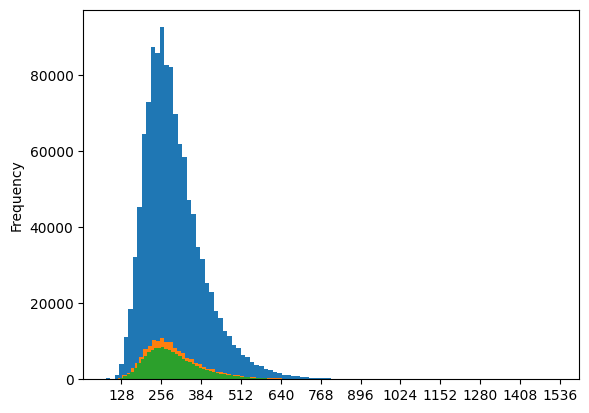

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.xticks(np.arange(0, 2**11, 2**7))
pd.Series(a).plot.hist(bins=100)
pd.Series(b).plot.hist(bins=100)
pd.Series(c).plot.hist(bins=100)

## Continue

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("BlackSamorez/TinyLlama-1_1B-Chat-v1_0-AQLM-2Bit-1x16-hf")

In [ ]:
from transformers import LlamaModel, AutoTokenizer, LlamaForCausalLM, LlamaConfig, LlamaForSequenceClassification
# _attn_implementation: flash_attention_2
model = LlamaForSequenceClassification.from_pretrained(
    "BlackSamorez/TinyLlama-1_1B-Chat-v1_0-AQLM-2Bit-1x16-hf",
	config=LlamaConfig.from_json_file("./llama_config.json"),
    ignore_mismatched_sizes=True,
	torch_dtype="auto", device_map="auto", low_cpu_mem_usage=True
)
model.cuda()
model.train()
model.num_parameters()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at BlackSamorez/TinyLlama-1_1B-Chat-v1_0-AQLM-2Bit-1x16-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


267885568

## memory usage for aqlm llama

In [ ]:
import numpy as np
np.array([np.array(list(t.shape)).prod() for t in model.state_dict().values()]).sum()

268399110

In [ ]:
import numpy as np
[(name, np.array(list(t.shape)).prod()) for name, t in model.state_dict().items()]

[('model.embed_tokens.weight', 65536000),
 ('model.layers.0.self_attn.q_proj.codebooks', 524288),
 ('model.layers.0.self_attn.q_proj.codes', 524288),
 ('model.layers.0.self_attn.q_proj.scales', 2048),
 ('model.layers.0.self_attn.k_proj.codebooks', 524288),
 ('model.layers.0.self_attn.k_proj.codes', 65536),
 ('model.layers.0.self_attn.k_proj.scales', 256),
 ('model.layers.0.self_attn.v_proj.codebooks', 524288),
 ('model.layers.0.self_attn.v_proj.codes', 65536),
 ('model.layers.0.self_attn.v_proj.scales', 256),
 ('model.layers.0.self_attn.o_proj.codebooks', 524288),
 ('model.layers.0.self_attn.o_proj.codes', 524288),
 ('model.layers.0.self_attn.o_proj.scales', 2048),
 ('model.layers.0.mlp.gate_proj.codebooks', 524288),
 ('model.layers.0.mlp.gate_proj.codes', 1441792),
 ('model.layers.0.mlp.gate_proj.scales', 5632),
 ('model.layers.0.mlp.up_proj.codebooks', 524288),
 ('model.layers.0.mlp.up_proj.codes', 1441792),
 ('model.layers.0.mlp.up_proj.scales', 5632),
 ('model.layers.0.mlp.down_pro

In [ ]:
# executed with quantized model loaded
torch.cuda.max_memory_allocated()

560665088

In [ ]:
560665088/268399110*8

16.711384415544448

In [ ]:
560665088/1034524672*8

4.335634350149167

## compare normal LLama

In [ ]:
from transformers import LlamaForSequenceClassification
# _attn_implementation: flash_attention_2
llama_model = LlamaForSequenceClassification.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
	torch_dtype="auto", device_map="auto", low_cpu_mem_usage=True
)
llama_model.cuda()
llama_model.train()
llama_model.num_parameters()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1034524672

In [ ]:
import numpy as np
[(name, np.array(list(t.shape)).prod()) for name, t in llama_model.state_dict().items()]

[('model.embed_tokens.weight', 65536000),
 ('model.layers.0.self_attn.q_proj.weight', 4194304),
 ('model.layers.0.self_attn.k_proj.weight', 524288),
 ('model.layers.0.self_attn.v_proj.weight', 524288),
 ('model.layers.0.self_attn.o_proj.weight', 4194304),
 ('model.layers.0.mlp.gate_proj.weight', 11534336),
 ('model.layers.0.mlp.up_proj.weight', 11534336),
 ('model.layers.0.mlp.down_proj.weight', 11534336),
 ('model.layers.0.input_layernorm.weight', 2048),
 ('model.layers.0.post_attention_layernorm.weight', 2048),
 ('model.layers.1.self_attn.q_proj.weight', 4194304),
 ('model.layers.1.self_attn.k_proj.weight', 524288),
 ('model.layers.1.self_attn.v_proj.weight', 524288),
 ('model.layers.1.self_attn.o_proj.weight', 4194304),
 ('model.layers.1.mlp.gate_proj.weight', 11534336),
 ('model.layers.1.mlp.up_proj.weight', 11534336),
 ('model.layers.1.mlp.down_proj.weight', 11534336),
 ('model.layers.1.input_layernorm.weight', 2048),
 ('model.layers.1.post_attention_layernorm.weight', 2048),
 ('m

In [ ]:
# executed with bert model loaded
torch.cuda.max_memory_allocated()

2085837824

In [ ]:
2085837824/1034524672*8

16.129825651949265

## Train

In [ ]:
from peft import AdaLoraConfig, get_peft_model, IA3Model, IA3Config, LoraConfig

lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
	inference_mode = False,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.01,
)
peft_model = get_peft_model(model, lora_config)
peft_model.get_parameter("base_model.model.score.weight").requires_grad = True
peft_model.get_parameter("base_model.model.score.weight").data = peft_model.get_parameter("base_model.model.score.weight").data.to(torch.float32)
peft_model.print_trainable_parameters()

trainable params: 50,475,008 || all params: 318,348,288 || trainable%: 15.855278606053004


In [ ]:
peft_model

PeftModel(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048, padding_idx=2)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): lora.AqlmLoraLinear(
                (base_layer): QuantizedLinear()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.AqlmLoraLinear(
                (base_layer): QuantizedLinear()
   

In [ ]:
[(name, p.requires_grad) for name, p in peft_model.named_parameters()]

[('base_model.model.model.embed_tokens.weight', False),
 ('base_model.model.model.layers.0.self_attn.q_proj.base_layer.codebooks',
  False),
 ('base_model.model.model.layers.0.self_attn.q_proj.base_layer.codes', False),
 ('base_model.model.model.layers.0.self_attn.q_proj.base_layer.scales', False),
 ('base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight',
  True),
 ('base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight',
  True),
 ('base_model.model.model.layers.0.self_attn.k_proj.base_layer.codebooks',
  False),
 ('base_model.model.model.layers.0.self_attn.k_proj.base_layer.codes', False),
 ('base_model.model.model.layers.0.self_attn.k_proj.base_layer.scales', False),
 ('base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight',
  True),
 ('base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight',
  True),
 ('base_model.model.model.layers.0.self_attn.v_proj.base_layer.codebooks',
  False),
 ('base_model.model.model.layer

In [ ]:
from peft.tuners.lora.aqlm import AqlmLoraLinear
from aqlm import QuantizedLinear
galore_params = []
target_modules_list = ["self_attn", "mlp"]
for module_name, module in peft_model.named_modules():
    if not isinstance(module, AqlmLoraLinear):
        continue

    if not any(target_key in module_name for target_key in target_modules_list):
        continue
    galore_params.append(module.lora_A.default.weight)
    galore_params.append(module.lora_B.default.weight)

In [ ]:
len(galore_params)

308

In [ ]:
id_galore_params = [id(p) for p in galore_params]
# make parameters without "rank" to another group
regular_params = [p for p in model.parameters() if id(p) not in id_galore_params]
# then call galore_adamw
param_groups = [{'params': regular_params}, 
				{'params': galore_params, 'rank': 8, 'update_proj_gap': 200, 'scale': 0.25, 'proj_type': 'std'}]

In [ ]:
from galore_torch import GaLoreAdamW8bit
optimizer = GaLoreAdamW8bit(param_groups, lr=2e-5)

In [ ]:
from evaluate import load
def collate_fn(inputs):
  input_attn = [tokenizer(iids['input_ids'], padding="max_length", truncation="only_first", max_length=512) for iids in inputs]
  return {
    'input_ids': torch.tensor([ia['input_ids'] for ia in input_attn], dtype=torch.int32),
    'attention_mask': torch.tensor([ia['attention_mask'] for ia in input_attn], dtype=torch.int32),
    'labels': torch.tensor([iids['labels'] for iids in inputs], dtype=torch.long)
  }
def compute_metrics(eval_preds):
  metrics = dict()
  accuracy_metric = load('accuracy')
  precision_metric = load('precision')
  recall_metric = load('recall')
  f1_metric = load('f1')


  preds = eval_preds.predictions.argmax(axis=1)
  labels = eval_preds.label_ids
  metrics.update(accuracy_metric.compute(predictions=preds, references=labels))
  metrics.update(precision_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(recall_metric.compute(predictions=preds, references=labels, average='weighted', zero_division=0))
  metrics.update(f1_metric.compute(predictions=preds, references=labels, average='weighted'))

  return metrics

In [ ]:
from transformers import TrainingArguments, Trainer
batch_size = 1

args = TrainingArguments(
    "tinyllama_soda_corrected",
    remove_unused_columns=False,
    # evaluation_strategy="epoch",
    # save_strategy="epoch",
    evaluation_strategy="steps",
	eval_steps=0.0999,
    save_strategy="steps",
	save_steps=0.0999,
    learning_rate=2e-5,
	lr_scheduler_type = "constant",
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=16,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=1,
    logging_steps=4,
    load_best_model_at_end=True,
    
    label_names=["labels"],
	report_to="wandb"
)

In [ ]:
from transformers.optimization import get_constant_schedule
trainer = Trainer(
    peft_model,
    args,
    train_dataset=ds['train'].shard(10, 0),
    eval_dataset=ds['test'].shard(10, 0),
    tokenizer=tokenizer,
	optimizers=(optimizer, get_constant_schedule(optimizer)),
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
)

In [ ]:
trainer.train()

wandb: Currently logged in as: picokatx. Use `wandb login --relogin` to force relogin


  0%|          | 0/7447 [00:00<?, ?it/s]

KeyboardInterrupt: 

## try to reduce mem

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()
trainer.create_optimizer_and_scheduler(3000)
optimizer = trainer.optimizer
scheduler = trainer.lr_scheduler
training_dataloader = trainer.get_train_dataloader()
model, optimizer, training_dataloader, scheduler = accelerator.prepare(
    model, optimizer, training_dataloader, scheduler
)
batch = next(iter(training_dataloader))
optimizer.zero_grad()
inputs = batch

In [ ]:
outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=inputs["labels"])


In [ ]:
model.model.layers[0].mlp.gate_proj.out_features

5632

In [ ]:
model.model.layers[0]

LlamaDecoderLayer(
  (self_attn): LlamaFlashAttention2(
    (q_proj): lora.AqlmLoraLinear(
      (base_layer): QuantizedLinear()
      (lora_dropout): ModuleDict(
        (default): Dropout(p=0.01, inplace=False)
      )
      (lora_A): ModuleDict(
        (default): Linear(in_features=2048, out_features=8, bias=False)
      )
      (lora_B): ModuleDict(
        (default): Linear(in_features=8, out_features=2048, bias=False)
      )
      (lora_embedding_A): ParameterDict()
      (lora_embedding_B): ParameterDict()
    )
    (k_proj): lora.AqlmLoraLinear(
      (base_layer): QuantizedLinear()
      (lora_dropout): ModuleDict(
        (default): Dropout(p=0.01, inplace=False)
      )
      (lora_A): ModuleDict(
        (default): Linear(in_features=2048, out_features=8, bias=False)
      )
      (lora_B): ModuleDict(
        (default): Linear(in_features=8, out_features=256, bias=False)
      )
      (lora_embedding_A): ParameterDict()
      (lora_embedding_B): ParameterDict()
    )
   

In [ ]:
model.model.layers[0].mlp.gate_proj

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_is_hf_initialized',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_no

In [ ]:
5632*128*8*23*2/10**9

0.265289728

In [ ]:
4096*2048*8*23/10**9

1.543503872

In [ ]:
outputs.hidden_states[2].shape

torch.Size([8, 128, 2048])

In [ ]:
loss = outputs.loss
accelerator.backward(loss)
optimizer.step()
scheduler.step()

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()
trainer.create_optimizer_and_scheduler(3000)
optimizer = trainer.optimizer
scheduler = trainer.lr_scheduler
training_dataloader = trainer.get_train_dataloader()
model, optimizer, training_dataloader, scheduler = accelerator.prepare(
    model, optimizer, training_dataloader, scheduler
)

for batch in training_dataloader:
    optimizer.zero_grad()
    inputs = batch
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=inputs["labels"], use_cache=False)
    loss = outputs.loss
    accelerator.backward(loss)
    optimizer.step()
    scheduler.step()

KeyboardInterrupt: 

In [ ]:
trainer.train()

  0%|          | 0/3723 [00:00<?, ?it/s]

{'loss': 1.8728, 'grad_norm': 30.34687042236328, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 2.2417, 'grad_norm': 39.659637451171875, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 1.8783, 'grad_norm': 30.25309944152832, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 1.7977, 'grad_norm': 32.13945007324219, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 1.9002, 'grad_norm': 24.224674224853516, 'learning_rate': 1e-05, 'epoch': 0.01}


KeyboardInterrupt: 

In [ ]:
from transformers import TrainerCallback
class ProfCallback(TrainerCallback):
    def __init__(self, prof):
        self.prof = prof
    def on_substep_end(self, args, state, control, **kwargs):
        self.prof.step()

In [ ]:
with torch.profiler.profile(
	activities=[
		torch.profiler.ProfilerActivity.CPU,
		torch.profiler.ProfilerActivity.CUDA,
	],
	schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
	record_shapes=True,
	profile_memory=True,
	with_stack=True,
) as prof:
	callback = ProfCallback(prof)
	trainer.add_callback(callback)
	trainer.train()

d:\projects\affect\TUCORE-GCN\.venv\Lib\site-packages\torch\profiler\profiler.py:339: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  0%|          | 0/3723 [00:00<?, ?it/s]

{'loss': 2.1383, 'grad_norm': nan, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 2.3837, 'grad_norm': 56.449676513671875, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 1.9804, 'grad_norm': 45.62903594970703, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 1.9266, 'grad_norm': 37.55613327026367, 'learning_rate': 1e-05, 'epoch': 0.0}


KeyboardInterrupt: 

In [ ]:
prof.export_chrome_trace("btephe.json")

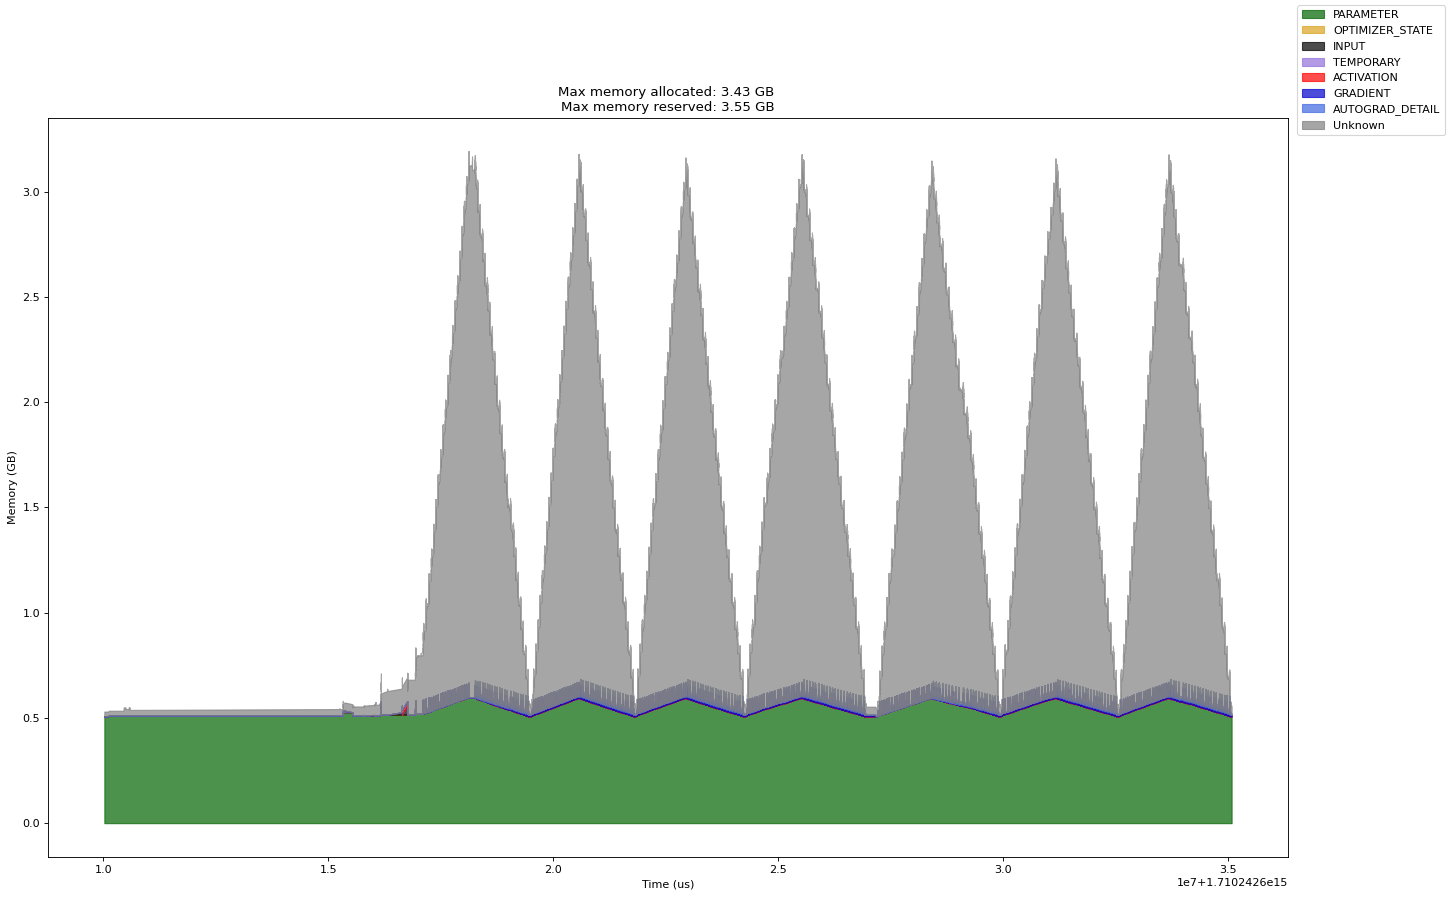

In [ ]:
prof.export_memory_timeline(f"hrwhrwhw.html", device="cuda:0")

In [ ]:
trainer.pop_callback(callback)

In [ ]:
callback = ProfCallback()
trainer.add_callback(callback)
trainer.train()

In [ ]:
out = peft_model(
	input_ids = torch.LongTensor([tokenizer.build_inputs_with_special_tokens(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I want pumpkin pie!!!!")))]).cuda(),
	labels = torch.LongTensor([1]).cuda(),
	output_hidden_states=True,
	output_attentions=True
)
loss, logits, past_key_vals, attn = out.loss, out.logits, out.past_key_values, out.attentions